In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd drive/MyDrive
%cp mask_dataset_7k.zip /content/

[Errno 2] No such file or directory: 'drive/MyDrive'
/content/drive/MyDrive


In [6]:
%cd /content/
!unzip mask_dataset_7k.zip

Streaming output truncated to the last 5000 lines.
  inflating: mask_dataset_7k/without_mask/face_411.jpg  
  inflating: mask_dataset_7k/without_mask/face_412.jpg  
  inflating: mask_dataset_7k/without_mask/face_413.jpg  
  inflating: mask_dataset_7k/without_mask/face_414.jpg  
  inflating: mask_dataset_7k/without_mask/face_415.jpg  
  inflating: mask_dataset_7k/without_mask/face_416.jpg  
  inflating: mask_dataset_7k/without_mask/face_417.jpg  
  inflating: mask_dataset_7k/without_mask/face_418.jpg  
  inflating: mask_dataset_7k/without_mask/face_419.jpg  
  inflating: mask_dataset_7k/without_mask/face_42.jpg  
  inflating: mask_dataset_7k/without_mask/face_420.jpg  
  inflating: mask_dataset_7k/without_mask/face_421.jpg  
  inflating: mask_dataset_7k/without_mask/face_422.jpg  
  inflating: mask_dataset_7k/without_mask/face_423.jpg  
  inflating: mask_dataset_7k/without_mask/face_424.jpg  
  inflating: mask_dataset_7k/without_mask/face_425.jpg  
  inflating: mask_dataset_7k/without_m

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [2]:
imagePaths = list(paths.list_images('mask_dataset_7k'))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [3]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [4]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
mobilenet_model = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
model_head = mobilenet_model.output
model_head = AveragePooling2D(pool_size=(7, 7))(model_head)
model_head = Flatten(name="flatten")(model_head)
model_head = Dense(128, activation="relu")(model_head)
model_head = Dropout(0.5)(model_head)
model_head = Dense(2, activation="softmax")(model_head)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=mobilenet_model.input, outputs=model_head)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in mobilenet_model.layers:
	layer.trainable = False

In [5]:
learning_rate = 1e-4
epochs = 20
batch_size = 32

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=learning_rate, decay=learning_rate/ epochs)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the head of the network
print("[INFO] training head...")
model_result = model.fit(
	aug.flow(trainX, trainY, batch_size=batch_size),
	steps_per_epoch=len(trainX) // batch_size,
	validation_data=(testX, testY),
	validation_steps=len(testX) // batch_size,
	epochs=epochs)

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
202/202 [==============================] - 78s 333ms/step - loss: 0.4230 - accuracy: 0.8223 - val_loss: 0.0881 - val_accuracy: 0.9759
Epoch 2/20
202/202 [==============================] - 65s 322ms/step - loss: 0.0927 - accuracy: 0.9768 - val_loss: 0.0635 - val_accuracy: 0.9808
Epoch 3/20
202/202 [==============================] - 65s 321ms/step - loss: 0.0722 - accuracy: 0.9785 - val_loss: 0.0558 - val_accuracy: 0.9827
Epoch 4/20
202/202 [==============================] - 65s 321ms/step - loss: 0.0612 - accuracy: 0.9795 - val_loss: 0.0519 - val_accuracy: 0.9839
Epoch 5/20
202/202 [==============================] - 65s 322ms/step - loss: 0.0503 - accuracy: 0.9828 - val_loss: 0.0443 - val_accuracy: 0.9889
Epoch 6/20
202/202 [==============================] - 65s 322ms/step - loss: 0.0441 - accuracy: 0.9875 - val_loss: 0.0419 - val_accuracy: 0.9895
Epoch 7/20
202/202 [==============================] - 65s 323ms/step - loss: 0.0

In [9]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=batch_size)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save('mask_detector.model', save_format="h5")

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.99       809
without_mask       0.99      0.98      0.99       809

    accuracy                           0.99      1618
   macro avg       0.99      0.99      0.99      1618
weighted avg       0.99      0.99      0.99      1618

[INFO] saving mask detector model...


In [16]:
model.save('mask_detector.model', save_format="h5")

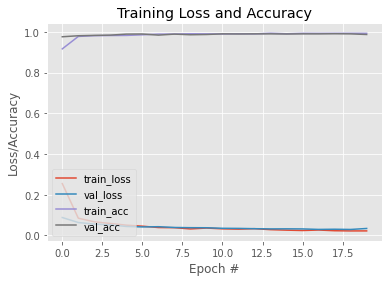

In [10]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), model_result.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), model_result.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), model_result.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), model_result.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('plot.png')